In [2]:
from aggregate_cross_validation_data import aggregate_cross_val_data

genes = open("training_results_v2/v2_repr_contrastive/genes.txt").read().split("\n")

# cell results
cell_aurocs, cell_spearmans, cell_mses = aggregate_cross_val_data(
    "./training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}"
)

# cnn results
cnn_aurocs, cnn_spearmans, cnn_mses = aggregate_cross_val_data(
    "./training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}"
)


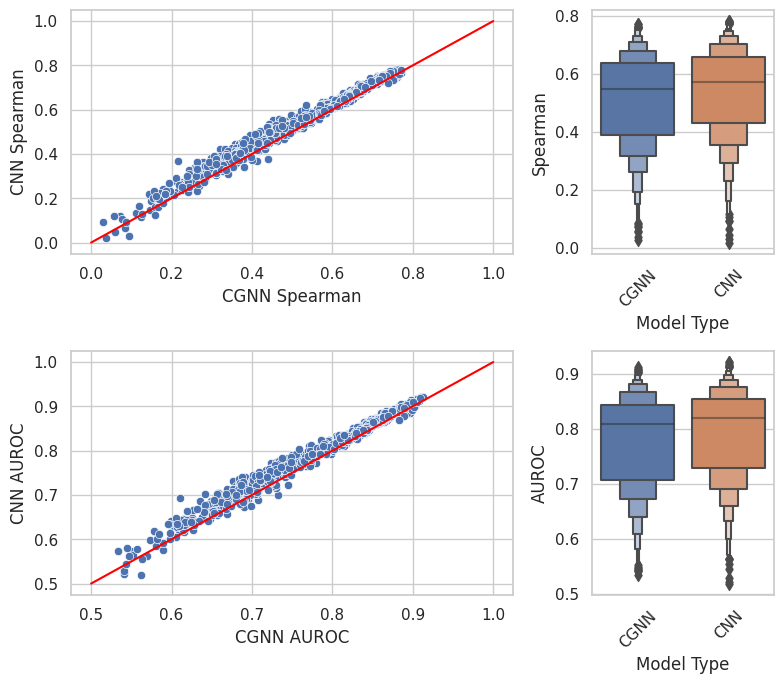

In [3]:
# Scatterplot: cell vs cnn spearman values and MSEs (auroc is correlated to spearman and might not be too diff)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np

def create_plot(aurocs1, aurocs2, spearmans1, spearmans2, name1, name2):
    aurocs_df = pd.DataFrame.from_dict({name1: aurocs1, name2: aurocs2})
    aurocs_df = aurocs_df.melt(var_name='Model Type', value_name='AUROC')

    spearmans_df = pd.DataFrame.from_dict({name1: spearmans1, name2: spearmans2})
    spearmans_df = spearmans_df.melt(var_name='Model Type', value_name='Spearman')

    sns.set_theme(style="whitegrid")

    fig = plt.figure(figsize=(8, 7))
    gs = GridSpec(4, 3, fig)

    ### SPEARMAN VALUES ###

    ax_scatter = fig.add_subplot(gs[:2, :2])
    ax_boxenplot = fig.add_subplot(gs[:2, 2])

    # For some reason, this title shows up above the boxenplot
    # plt.title("Results for CGNN vs. CNN")
    sns.scatterplot(x=spearmans1, y=spearmans2, ax=ax_scatter)
    sns.lineplot(x=[0, 1], y=[0, 1], color="red", ax=ax_scatter)
    ax_scatter.set_xlabel(name1 + " Spearman")
    ax_scatter.set_ylabel(name2 + " Spearman")

    sns.boxenplot(x="Model Type", y="Spearman", data=spearmans_df, ax=ax_boxenplot)
    plt.xticks(rotation=45)

    ax_scatter = fig.add_subplot(gs[2:, :2])
    ax_boxenplot = fig.add_subplot(gs[2:, 2])

    sns.scatterplot(x=aurocs1, y=aurocs2, ax=ax_scatter)
    sns.lineplot(x=[0.5, 1], y=[0.5, 1], color="red", ax=ax_scatter)
    ax_scatter.set_xlabel(name1 + " AUROC")
    ax_scatter.set_ylabel(name2 + " AUROC")

    sns.boxenplot(x="Model Type", y="AUROC", data=aurocs_df, ax=ax_boxenplot)
    plt.xticks(rotation=45)

    plt.tight_layout()

    plt.show()

create_plot(
    cell_aurocs, cnn_aurocs, cell_spearmans, cnn_spearmans, "CGNN", "CNN"
)

# plt.savefig("figures/cell_vs_cnn_spearman_scatter.png")
# plt.clf()

# sns.scatterplot(x=cell_mses, y=cnn_mses)
# sns.lineplot(x=[0, max(cell_mses)], y=[0, max(cell_mses)], color="red")

# plt.title("MSE values for CGNN vs. CNN")
# plt.xlabel("CGNN MSE")
# plt.ylabel("CNN MSE")
# plt.tight_layout()

# plt.savefig("figures/cell_vs_cnn_mse_scatter.png")

# plt.clf()


In [8]:
genes = open("training_results_v2/v2_repr_contrastive/genes.txt").read().split("\n")
cv_results = {}
for prior in ['none', 'repr']:
    for cre in [False, True]:
        cre_str = 'cellreg-enabled_' if cre else ''
        aurocs, spearmans, mses = aggregate_cross_val_data(
            f"./training_results_v2/v2_repr_contrastive/cellmodel_prior-{prior}_{cre_str}heldout-{{patient}}"
        )
        cre_str = 'true' if cre else 'false'
        cv_results[f'cell_reg:{cre_str},prior:{prior}'] = {
            "aurocs": list(aurocs),
            "spearmans": list(spearmans),
            "mses": list(mses)
        }

Skipping ./training_results_v2/v2_repr_contrastive/cellmodel_prior-none_heldout-092842_16 due to [Errno 2] No such file or directory: './training_results_v2/v2_repr_contrastive/cellmodel_prior-none_heldout-092842_16_stats.json'
Skipping ./training_results_v2/v2_repr_contrastive/cellmodel_prior-repr_heldout-092842_17 due to [Errno 2] No such file or directory: './training_results_v2/v2_repr_contrastive/cellmodel_prior-repr_heldout-092842_17_stats.json'


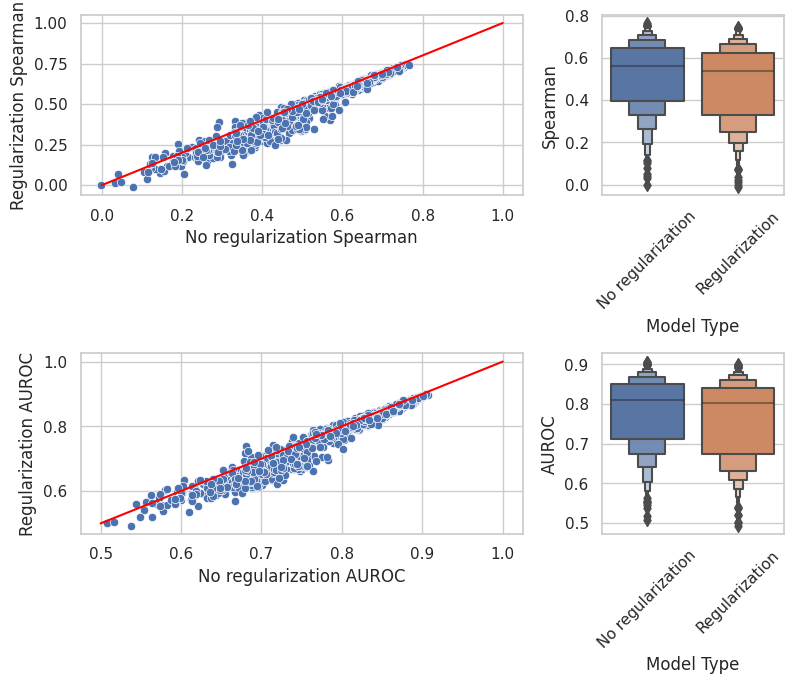

In [12]:
create_plot(
    cv_results['cell_reg:false,prior:none']['aurocs'],
    cv_results['cell_reg:true,prior:none']['aurocs'],
    cv_results['cell_reg:false,prior:none']['spearmans'],
    cv_results['cell_reg:true,prior:none']['spearmans'],
    'No regularization', 'Regularization',
)

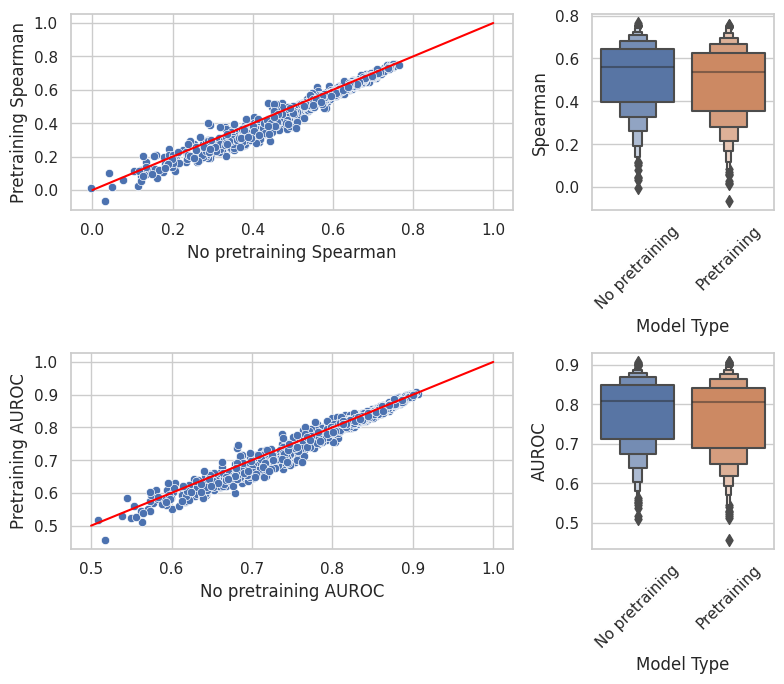

In [14]:
create_plot(
    cv_results['cell_reg:false,prior:none']['aurocs'],
    cv_results['cell_reg:false,prior:repr']['aurocs'],
    cv_results['cell_reg:false,prior:none']['spearmans'],
    cv_results['cell_reg:false,prior:repr']['spearmans'],
    'No pretraining', 'Pretraining',
)

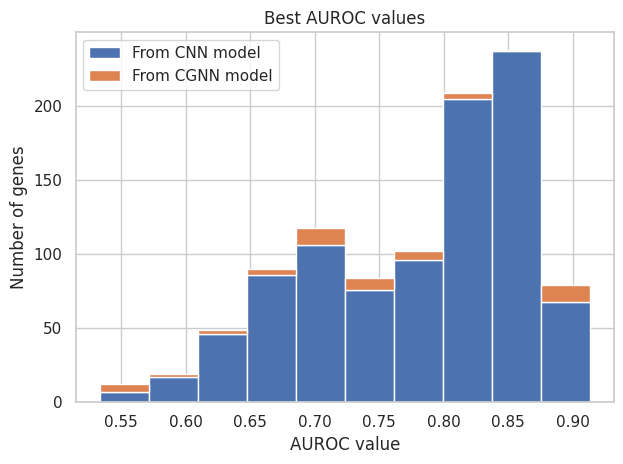

In [6]:
# AUROC histogram (taking best from each)

cnn_wins = []
cell_wins = []
for (a, b) in zip(cnn_aurocs, cell_aurocs):
    if a > b:
        cnn_wins.append(b)
    else:
        cell_wins.append(b)

plt.title("Best AUROC values")
plt.hist([cnn_wins, cell_wins], stacked=True, label=['From CNN model', 'From CGNN model'])
plt.legend()
plt.xlabel("AUROC value")
plt.ylabel("Number of genes")
plt.tight_layout()
plt.show()


In [6]:


plt.title("AUROC values")

plt.tight_layout()
plt.savefig("figures/auroc_boxenplot.png")

plt.clf()

plt.title("Spearman values")
sns.boxenplot(x="variant", y="Spearman", data=spearmans_df)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/spearman_boxenplot.png")

plt.clf()


<Figure size 640x480 with 0 Axes>

In [16]:
def bootstrap(values):
    values = values[~np.isnan(values)]
    np.random.seed(42)
    performances_bootstrapped=[np.quantile(np.random.choice(values,len(values),replace=True),0.5) for i in range(1000)]
    med = np.quantile(values,0.5)
    p975 = np.quantile(performances_bootstrapped,[0.025,0.975])
    return {"median": med, "width": (p975[1]-p975[0])/2}

In [17]:
# result for best model

spearman_results = np.zeros_like(cell_spearmans)
auroc_results = np.zeros_like(cell_aurocs)

for prior in ['none', 'repr']:
    for cre in ['false', 'true']:
        key = f'cell_reg:{cre},prior:{prior}'
        spearman_results = np.maximum(spearman_results, cv_results[key]['spearmans'])
        auroc_results = np.maximum(auroc_results, cv_results[key]['aurocs'])

print(bootstrap(spearman_results))
print(bootstrap(auroc_results))

{'median': 0.5636735852263861, 'width': 0.013543238736048291}
{'median': 0.8137777961536019, 'width': 0.006857547497954197}
